<a href="https://colab.research.google.com/github/yuvala15/DL_COURSE_PROJECT/blob/main/DL_COURSE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the dataset from git

In [ ]:
!git clone https://github.com/yuvala15/DL_COURSE_PROJECT.git

Cloning into 'DL_COURSE_PROJECT'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 13 (delta 1), reused 6 (delta 1), pack-reused 7
Unpacking objects: 100% (13/13), done.


In [ ]:
!unzip -qq  DL_COURSE_PROJECT/data/fer20131.zip -d datasets/

Import modules


In [ ]:
import os
import numpy as np 
import pandas as pd
import albumentations
from albumentations import pytorch as AT
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from torchsummary import summary

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
import torch.optim as optim

import torch.nn.functional as F
import torch.nn as nn

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

%matplotlib inline

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Read the dataset

In [ ]:
dataset = pd.read_csv('./datasets/fer20131.csv')
dataset.info()
dataset.head()
dataset.Usage.value_counts()
dataset.value_counts()

dataset.Usage.unique()
print(len(dataset[dataset.Usage=='Training']))
print(len(dataset[dataset.Usage=='PublicTest']))
print(len(dataset[dataset.Usage=='PrivateTest']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
28709
3589
3589


Defining the labels

In [ ]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

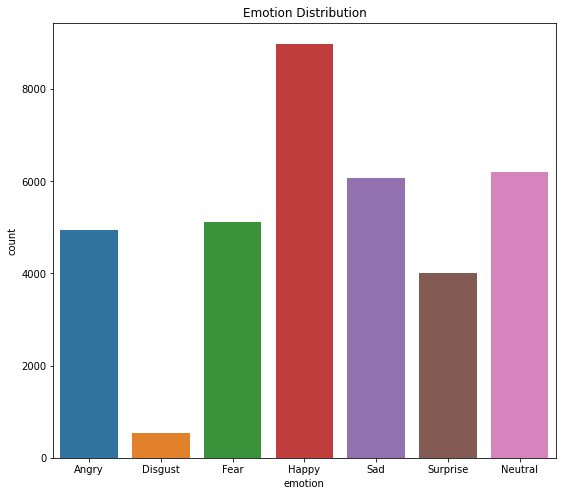

In [ ]:
plt.figure(figsize=(9, 8))
sns.countplot(x=dataset.emotion)
_ = plt.title('Emotion Distribution')
_ = plt.xticks(ticks=range(0, 7), labels=[emotions[i] for i in range(0, 7)], )

Create an array from pixels object and append it to the dataset

In [ ]:
dataset['pixels-array']=[[int(y) for y in x.split()] for x in dataset['pixels']]

In [ ]:
dataset.head()

,emotion,pixels,Usage,pixels-array
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


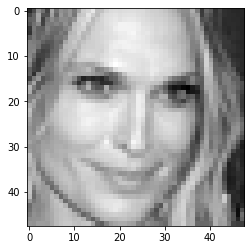

In [ ]:
img_pixels=np.array(dataset['pixels-array'][20000])
img_pixels_shaped=img_pixels.reshape(48,48)
plt.imshow(img_pixels_shaped, interpolation='nearest',cmap='gray')
plt.show()

Split the dataset to training, validation and test sets

In [ ]:
train_set=dataset[dataset.Usage=='Training']
validation_set=dataset[dataset.Usage=='PrivateTest']
test_set=dataset[dataset.Usage=='PublicTest']

part={}
part['train']= list(range(0,len(train_set)))
part['valid']= list(range(0,len(validation_set)))
part['test']= list(range(0,len(test_set)))
train_labels=train_set['emotion'].tolist()
valid_labels=validation_set['emotion'].tolist()
test_labels=test_set['emotion'].tolist()

In [ ]:
print(train_set[:10])
print(train_labels[:10])

   emotion  ...                                       pixels-array
0        0  ...  [70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...
1        0  ...  [151, 150, 147, 155, 148, 133, 111, 140, 170, ...
2        2  ...  [231, 212, 156, 164, 174, 138, 161, 173, 182, ...
3        4  ...  [24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...
4        6  ...  [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...
5        2  ...  [55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...
6        4  ...  [20, 17, 19, 21, 25, 38, 42, 42, 46, 54, 56, 6...
7        3  ...  [77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...
8        3  ...  [85, 84, 90, 121, 101, 102, 133, 153, 153, 169...
9        2  ...  [255, 254, 255, 254, 254, 179, 122, 107, 95, 1...

[10 rows x 4 columns]
[0, 0, 2, 4, 6, 2, 4, 3, 3, 2]


Define dataset class which holds regaular images and augmented images

In [ ]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

  def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = self.dff.iloc[index]['pixels-array'] # Get pixels-array by Integer location by the current index in the dff
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion'] # Get emotion by Integer location by the current index in the dff

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

Hyper parameters of the neural network 

In [ ]:
params = {'batch_size': 64,'shuffle': True}
criterion = nn.CrossEntropyLoss()
epochs=9

Defining wrapper class that handles the augmented images

In [ ]:
class AlbumentationWrapper(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
                albumentations.Normalize((0.5), (0.5)),
                AT.ToTensor()
                ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([                               
                    albumentations.HorizontalFlip(),
                    albumentations.Cutout(2,2,2,0.5),
                    albumentations.GaussNoise(),
                    albumentations.Normalize((0.5), (0.5)),
                    AT.ToTensor()    
                    ])
            
    def __call__(self,img):
        img = self.aug(image=img)['image']
        return img

Create transformed images

In [ ]:
train_transforms , validation_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('validation')

In [ ]:
training_set = Dataset(train_set, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(validation_set, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(test_set, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

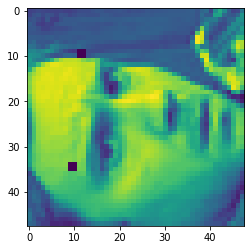

In [ ]:
img_pixels=np.array(train_set['pixels-array'][0])
img_pixels_shaped=img_pixels.reshape(48,48)
plt.imshow(training_set.transforms(img_pixels_shaped))
plt.show()

Prints graphs according to the parameters

In [ ]:
def plot(train_losses, validation_acc, label, sub_plot1, sub_plot2):
  fig, axs = plt.subplots(1,2,figsize=(20,8))

  axs[0].plot(train_losses, label=label)
  axs[0].set_xlabel(sub_plot1["xlabel"])
  axs[0].set_ylabel(sub_plot1["ylabel"])
  axs[0].set_title(sub_plot1["title"])
  axs[1].plot(validation_acc, label=label)
  axs[1].set_xlabel(sub_plot2["xlabel"])
  axs[1].set_ylabel(sub_plot2["ylabel"])
  axs[1].set_title(sub_plot2["title"])

Define the nueral network

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
         )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)


Define train model *function*

In [ ]:
def train(model, train_loader, optimizer):
  model.train()
  running_loss = 0.0
  correct = 0
  processed = 0
  did_print_epoch = False

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    train_acc.append(100*correct/processed)
    if(did_print_epoch == False):
      print(f'Loss={loss.item()} Accuracy={100*correct/processed:0.2f}')
      did_print_epoch = True

Define all the variables that will hold the results of the training and testing

In [ ]:
  train_acc = []
  train_loss = []
  valid_acc = []
  valid_loss = []

Define model test function

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

Running the training and the testing simultaneously so we can see the progress in real time

In [ ]:
def run_experiment(train_generator):
  model=Net(1.0)
  model.to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=9e-4)

  input_size=(3,48,48)

  for epoch in range(epochs):
      print("EPOCH: %s " % (epoch))
      train(model, train_generator, optimizer)
      test(model, validation_generator)

In [ ]:
%%time
run_experiment(training_generator)

EPOCH: 0 
Loss=2.0378518104553223 Accuracy=12.50

Test set: Average loss: 0.0232, Accuracy: 1587/3589 (44.22%)

EPOCH: 1 
Loss=1.6478787660598755 Accuracy=35.94

Test set: Average loss: 0.0221, Accuracy: 1738/3589 (48.43%)

EPOCH: 2 
Loss=1.4680795669555664 Accuracy=40.62

Test set: Average loss: 0.0186, Accuracy: 1988/3589 (55.39%)

EPOCH: 3 
Loss=1.3754565715789795 Accuracy=45.31

Test set: Average loss: 0.0181, Accuracy: 2050/3589 (57.12%)

EPOCH: 4 
Loss=1.4885978698730469 Accuracy=39.06

Test set: Average loss: 0.0174, Accuracy: 2114/3589 (58.90%)

EPOCH: 5 
Loss=1.4243770837783813 Accuracy=32.81

Test set: Average loss: 0.0170, Accuracy: 2140/3589 (59.63%)

EPOCH: 6 
Loss=1.3570294380187988 Accuracy=45.31

Test set: Average loss: 0.0173, Accuracy: 2080/3589 (57.95%)

EPOCH: 7 
Loss=1.4870200157165527 Accuracy=45.31

Test set: Average loss: 0.0169, Accuracy: 2129/3589 (59.32%)

EPOCH: 8 
Loss=1.3980493545532227 Accuracy=45.31

Test set: Average loss: 0.0161, Accuracy: 2224/3589 (6

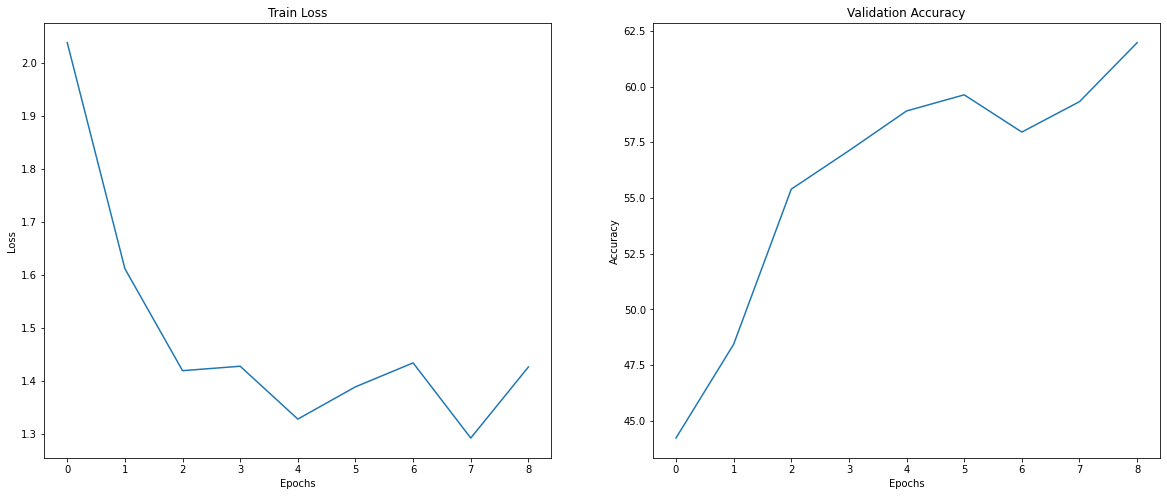

In [ ]:
plot1 = {}
plot1["title"] = "Train Loss"
plot1["xlabel"] = "Epochs"
plot1["ylabel"] = "Loss"

plot2 = {}
plot2["title"] = "Validation Accuracy"
plot2["xlabel"] = "Epochs"
plot2["ylabel"] = "Accuracy"

plot(train_loss[0::500], valid_acc, 'Loss & Accuracy', plot1, plot2)

Creates unalbumated training data

In [ ]:
unalbumated_train_transforms = AlbumentationWrapper('unalbumated_train')
training_set = Dataset(train_set, unalbumated_train_transforms)
unaugmented_training_generator = data.DataLoader(training_set, **params)

Reset the variables and running the experminet using the new unalbumated training data

In [ ]:
%%time
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
run_experiment(unaugmented_training_generator)

EPOCH: 0 
Loss=1.9827114343643188 Accuracy=9.38

Test set: Average loss: 0.0194, Accuracy: 1952/3589 (54.39%)

EPOCH: 1 
Loss=1.086427092552185 Accuracy=59.38

Test set: Average loss: 0.0174, Accuracy: 2088/3589 (58.18%)

EPOCH: 2 
Loss=0.9456384778022766 Accuracy=65.62

Test set: Average loss: 0.0169, Accuracy: 2154/3589 (60.02%)

EPOCH: 3 
Loss=0.7505905032157898 Accuracy=71.88

Test set: Average loss: 0.0178, Accuracy: 2070/3589 (57.68%)

EPOCH: 4 
Loss=0.6324546933174133 Accuracy=78.12

Test set: Average loss: 0.0163, Accuracy: 2218/3589 (61.80%)

EPOCH: 5 
Loss=0.6234635710716248 Accuracy=79.69

Test set: Average loss: 0.0185, Accuracy: 2142/3589 (59.68%)

EPOCH: 6 
Loss=0.3482566773891449 Accuracy=92.19

Test set: Average loss: 0.0206, Accuracy: 2110/3589 (58.79%)

EPOCH: 7 
Loss=0.4340094327926636 Accuracy=85.94

Test set: Average loss: 0.0213, Accuracy: 2179/3589 (60.71%)

EPOCH: 8 
Loss=0.2964884042739868 Accuracy=90.62

Test set: Average loss: 0.0218, Accuracy: 2232/3589 (62.

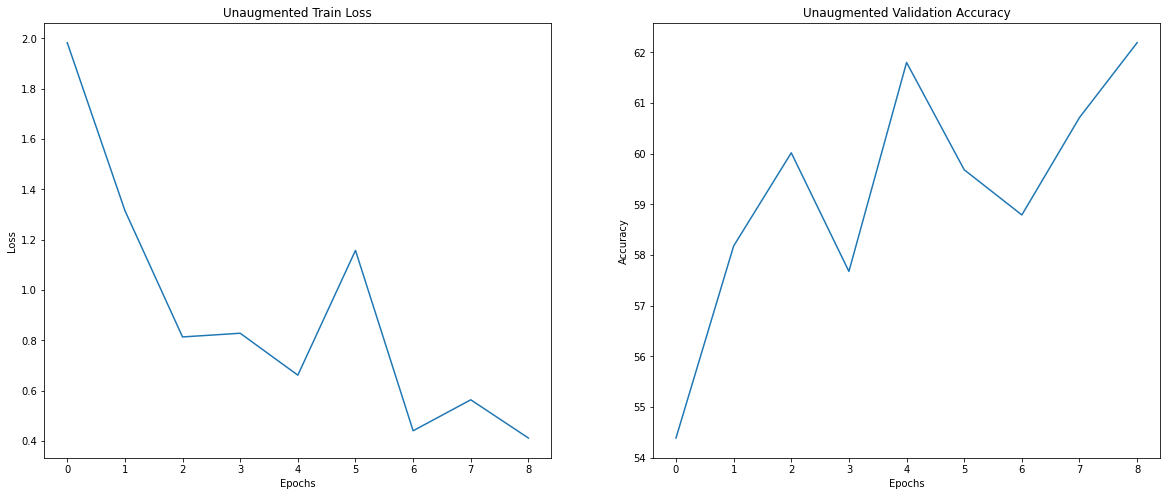

In [ ]:
plot1["title"] = "Unaugmented Train Loss"
plot1["xlabel"] = "Epochs"
plot1["ylabel"] = "Loss"

plot2["title"] = "Unaugmented Validation Accuracy"
plot2["xlabel"] = "Epochs"
plot2["ylabel"] = "Accuracy"

plot(train_loss[0::500], valid_acc, 'Loss & Accuracy', plot1, plot2)